<a href="https://colab.research.google.com/github/ysmeyyappan/team-12-summer-project/blob/Ashwini/facemask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files


In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ashwini2310","key":"b1acab04d78b55d241e864a88fc3e754"}'}

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download prithwirajmitra/covid-face-mask-detection-dataset

 97% 201M/207M [00:03<00:00, 71.6MB/s]
100% 207M/207M [00:03<00:00, 62.3MB/s]


In [ ]:
! unzip covid-face-mask-detection-dataset.zip

Archive:  covid-face-mask-detection-dataset.zip
  inflating: New Masks Dataset/Test/Mask/2070.jpg  
  inflating: New Masks Dataset/Test/Mask/2072.jpg  
  inflating: New Masks Dataset/Test/Mask/2083.jpg  
  inflating: New Masks Dataset/Test/Mask/2085.jpg  
  inflating: New Masks Dataset/Test/Mask/2086.jpg  
  inflating: New Masks Dataset/Test/Mask/2110.jpg  
  inflating: New Masks Dataset/Test/Mask/2113.jpg  
  inflating: New Masks Dataset/Test/Mask/2114.jpeg  
  inflating: New Masks Dataset/Test/Mask/2130.jpg  
  inflating: New Masks Dataset/Test/Mask/2132.jpg  
  inflating: New Masks Dataset/Test/Mask/2135.jpg  
  inflating: New Masks Dataset/Test/Mask/2154.png  
  inflating: New Masks Dataset/Test/Mask/2158.png  
  inflating: New Masks Dataset/Test/Mask/2159.png  
  inflating: New Masks Dataset/Test/Mask/2160.png  
  inflating: New Masks Dataset/Test/Mask/2170.png  
  inflating: New Masks Dataset/Test/Mask/2172.png  
  inflating: New Masks Dataset/Test/Mask/2173.png  
  inflating: Ne

In [ ]:
#importing the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 1e-4
EPOCHS = 15
BS = 22
dataset= 'dataset'

In [ ]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset))
data = []
labels = []

[INFO] loading images...


In [ ]:
DIRECTORY = r"/content/New Masks Dataset/Train"
CATEGORIES = ["Mask", "Non Mask"]
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(category)

In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [ ]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# partition the data into training and testing splits using 80% 
#of the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, 
      labels,test_size=0.20, stratify=labels, random_state=42)

In [ ]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
 rotation_range=20,
 zoom_range=0.15,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.15,
 horizontal_flip=True,
 fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))


9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# construct the head of the model that will be placed on top of the the base model
headModel = baseModel.output
headModel = MaxPooling2D(pool_size = (2, 2)) (headModel)
headModel = Conv2D(32,(2,2), activation="relu") (headModel)
headModel = AveragePooling2D(pool_size=(2, 2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


In [ ]:
# place the head FC model on top of the base model 
#(this is the actual model to be trained)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# not be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# compiling the model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
# train the head of the network
a=trainX[:100]
b=trainY[:100]
c=testX[:25]
d=testY[:25]
print(len(a))
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(a,b,batch_size=BS),
    steps_per_epoch=len(a) // BS,
    validation_data=(c,d),
    validation_steps=len(c) // BS,
    epochs=EPOCHS)


100
[INFO] training head...
Epoch 1/15
4/4 [==============================] - 7s 1s/step - loss: 0.8987 - accuracy: 0.5513 - val_loss: 0.6688 - val_accuracy: 0.6400
Epoch 2/15
4/4 [==============================] - 3s 809ms/step - loss: 0.7675 - accuracy: 0.6026 - val_loss: 0.5707 - val_accuracy: 0.7600
Epoch 3/15
4/4 [==============================] - 3s 831ms/step - loss: 0.6087 - accuracy: 0.7436 - val_loss: 0.4954 - val_accuracy: 0.8400
Epoch 4/15
4/4 [==============================] - 3s 828ms/step - loss: 0.5259 - accuracy: 0.7821 - val_loss: 0.4255 - val_accuracy: 0.9200
Epoch 5/15
4/4 [==============================] - 4s 880ms/step - loss: 0.4614 - accuracy: 0.8182 - val_loss: 0.3625 - val_accuracy: 0.9200
Epoch 6/15
4/4 [==============================] - 3s 838ms/step - loss: 0.4589 - accuracy: 0.8590 - val_loss: 0.3170 - val_accuracy: 0.9200
Epoch 7/15
4/4 [==============================] - 3s 794ms/step - loss: 0.3865 - accuracy: 0.8974 - val_loss: 0.2774 - val_accuracy: 0.

In [ ]:

print("[INFO] evaluating network...")
predIdxs = model.predict(c, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(d.argmax(axis=1), predIdxs,
     target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")


[INFO] evaluating network...
              precision    recall  f1-score   support

        Mask       0.93      1.00      0.96        13
    Non Mask       1.00      0.92      0.96        12

    accuracy                           0.96        25
   macro avg       0.96      0.96      0.96        25
weighted avg       0.96      0.96      0.96        25

[INFO] saving mask detector model...


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


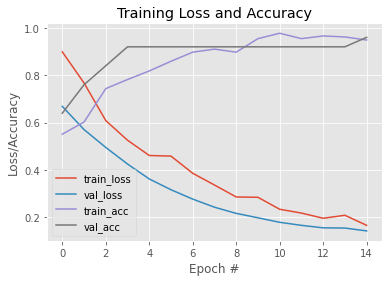

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")